<a href="https://colab.research.google.com/github/signLangProjectNIC/tf-cnn-lstm4/blob/main/TL_keras_VGG16_6_SUCCESS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import keras
import os
from PIL import Image
from matplotlib import pyplot as plt
from moviepy.editor import *
import cv2
import moviepy
import sys
import random
import tensorflow.keras.layers as tfKL
import sklearn
from tensorflow.keras import regularizers
from keras.layers import Activation, Dense 
from sklearn.model_selection import train_test_split
import time
from matplotlib import pyplot as plt
import random
import pandas as pd
from tensorflow import keras
from keras.applications.vgg16 import VGG16
from keras import Sequential
from keras.layers import Dense, Concatenate, Input, Lambda,LSTM,Reshape
from keras.models import Model

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
mainPath="/content/gdrive/MyDrive/hand sign database"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
nCategories=8

In [4]:
partition ={}
labels ={}

In [5]:
partition['train']=list()
partition['validation']=list()
partition['test']=list()

In [6]:
def mapCatToNumber(file1):
  strings=[]
  for cat in os.listdir(file1):
    strings.append(cat)
  stringsS=sorted(strings)
  answer={}
  for i in range(len(stringsS)):
    answer[stringsS[i]]=i
  return answer
mappingCatToN=mapCatToNumber(mainPath)
print(mappingCatToN)

{'accident': 0, 'call': 1, 'doctor': 2, 'help': 3, 'hot': 4, 'lose': 5, 'pain': 6, 'thief': 7}


In [7]:
for category in os.listdir(mainPath):
  print(category)
  vidL=[]
  for video in os.listdir(os.path.join(mainPath,category)):
    vidL.append(os.path.join(mainPath,category,video))
  lenVidL=len(vidL)
  trainLen=(int)(3*lenVidL/4)
  testLen=int(lenVidL/10)
  valLen=lenVidL-trainLen-testLen
  print(trainLen," ",valLen," ",testLen)
  random.shuffle(vidL)
  for i in range(lenVidL):
    labels[vidL[i]]=mappingCatToN[category]
    if i<trainLen:
      partition['train'].append(vidL[i])
    elif i<trainLen+valLen:
      partition['validation'].append(vidL[i])
    else:
      partition['test'].append(vidL[i])

call
39   8   5
lose
30   6   4
hot
39   8   5
help
39   8   5
thief
37   8   5
accident
39   8   5
doctor
39   8   5
pain
39   8   5


In [8]:
print(np.shape(partition['train']))
print(np.shape(partition['validation']))
print(np.shape(partition['test']))

(301,)
(62,)
(39,)


In [9]:
import numpy as np
import keras

class DataGenerator(keras.utils.Sequence):
  'Generates data for Keras'
  def __init__(self, list_IDs, labels, batch_size=32, dim=(20,224,224,3), n_classes=8, shuffle=True):
    'Initialization'
    self.dim = dim
    self.batch_size = batch_size
    self.labels = labels
    self.list_IDs = list_IDs
    self.n_classes = n_classes
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    'Denotes the number of batches per epoch'
    return int(np.floor(len(self.list_IDs) / self.batch_size))

  def __getitem__(self, index):
    'Generate one batch of data'
    # Generate indexes of the batch
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

    # Find list of IDs
    list_IDs_temp = [self.list_IDs[k] for k in indexes]

    # Generate data
    X, y = self.__data_generation(list_IDs_temp)

    return X, y

  def on_epoch_end(self):
    'Updates indexes after each epoch'
    self.indexes = np.arange(len(self.list_IDs))
    if self.shuffle == True:
        np.random.shuffle(self.indexes)

  def __data_generation(self, list_IDs_temp):
    'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
    # Initialization
    X = np.empty((self.batch_size, *self.dim))
    y = np.empty((self.batch_size), dtype=int)

    # Generate data
    for i, ID in enumerate(list_IDs_temp):
      # Store sample
      # X[i,] = np.load('data/' + ID + '.npy')
      ######
      # print(ID)
      try:
        vidObj = moviepy.editor.VideoFileClip(ID)
      except IOError as e:
        errno, strerror = e.args
        print(errno)
        print(strerror)
      video_duration = int(vidObj.duration)   
      nFrames=self.dim[0]
      array=np.empty(shape=(nFrames,224,224,3))
      frameSize=(self.dim[1],self.dim[2])
      for k in range(nFrames):
        frame=vidObj.get_frame((k+1)*video_duration/(nFrames*1.0))
        frameR=Image.fromarray(frame).convert("RGB")
        frame2=frameR.resize(frameSize)
        arrayi=np.array(frame2)/255
        # if k is 0:
        #   print(np.shape(arrayi))
        array[k]=arrayi
        del arrayi
      # print(np.shape(array))
      X[i,]=array
      del array
      #######
      # Store class
      y[i] = self.labels[ID]
    print("Shape of X output by data generator: ",np.shape(X))
    return np.array(X), keras.utils.to_categorical(y, num_classes=self.n_classes)

In [10]:
def createModel4(Tframes=20,batch_size=10,epochs=500,verbose=2,metrics=['accuracy'],loss='categorical_crossentropy',optimizer='adam',nLstmUnits=147):
  input=Input(shape=(Tframes,224,224,3))
  branchOutputs=[]
  for i in range(Tframes):
    out=Lambda(lambda x: x[:,i,:,:,:])(input)
    print("out.shape: ",out.shape)
    name="vgg16_"+str(i)
    tempModel=Sequential(name=name)
    tempModel.add(VGG16(include_top=False,input_shape=(224,224,3)))
    out1=tempModel(out)
    branchOutputs.append(out1)
  out = Concatenate()(branchOutputs)
  model=Model(inputs=input,outputs=out)
  model2=Sequential()
  model2.add(model)
  model2.add(tfKL.TimeDistributed(LSTM(units=nLstmUnits,activation='tanh',input_shape=(None,7,7,512))))
  model2.add(tfKL.Flatten())
  model2.add(Dense(units=8,activation='softmax'))
  model2.compile(optimizer=optimizer, loss=loss, metrics=metrics)
  return model2

In [11]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
with tf.device('/device:GPU:0'):
  Tframes=12
  batch_size=10
  params = {'dim': (Tframes,224,224,3),
            'batch_size': batch_size,
            'n_classes': 8,
            'shuffle': True}

  # Generators
  training_generator = DataGenerator(partition['train'], labels, **params)
  validation_generator = DataGenerator(partition['validation'], labels, **params)


  model=createModel4(Tframes=Tframes)
  begin=time.time()
  history=model.fit_generator(epochs=100,verbose=2,generator=training_generator,
                    validation_data=validation_generator)
  end=time.time()

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  print("Time taken: ",end-begin)

out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
Shape of X output by data generator:  (10, 12, 224, 224, 3)
Epoch 1/100
Shape of X output by data generator:  (10, 12, 224, 224, 3)
Shape of X output by data generator:  (10, 12, 224, 224, 3)
Shape of X output by data generator:  (10, 12, 224, 224, 3)
Shape of X output by data generator:  (10, 12, 224, 224, 3)
Shape of X output by data generator:  (10, 12, 224, 224, 3)
Shape of X output by data generator:  (10, 12, 224, 224, 3)
Shape of X output by data generator:  (10, 12, 224, 224, 3)
Shape of X output by data generator:  (10, 12, 224, 224, 3)
Shape of X output by data generator:  (10, 12, 224, 224, 3)
Shap

In [1]:
#this requires a whole lot of computational power and also i think underfitting is taking place

In [ ]:
with tf.device('/device:GPU:0'):
  Tframes=12
  batch_size=10
  nLstmUnits=1000
  params = {'dim': (Tframes,224,224,3),
            'batch_size': batch_size,
            'n_classes': 8,
            'shuffle': True}

  # Generators
  training_generator = DataGenerator(partition['train'], labels, **params)
  validation_generator = DataGenerator(partition['validation'], labels, **params)


  model=createModel4(Tframes=Tframes,nLstmUnits=nLstmUnits)
  begin=time.time()
  history=model.fit_generator(epochs=14,verbose=2,generator=training_generator,
                    validation_data=validation_generator)
  end=time.time()

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  print("Time taken: ",end-begin)

out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
Shape of X output by data generator:  (10, 12, 224, 224, 3)
Epoch 1/14
Shape of X output by data generator:  (10, 12, 224, 224, 3)
Shape of X output by data generator:  (10, 12, 224, 224, 3)
Shape of X output by data generator:  (10, 12, 224, 224, 3)
Shape of X output by data generator:  (10, 12, 224, 224, 3)
Shape of X output by data generator:  (10, 12, 224, 224, 3)
Shape of X output by data generator:  (10, 12, 224, 224, 3)
Shape of X output by data generator:  (10, 12, 224, 224, 3)
Shape of X output by data generator:  (10, 12, 224, 224, 3)
Shape of X output by data generator:  (10, 12, 224, 224, 3)
Shape

out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
Shape of X output by data generator:  (10, 12, 224, 224, 3)
Epoch 1/13
Shape of X output by data generator:  (10, 12, 224, 224, 3)
Shape of X output by data generator:  (10, 12, 224, 224, 3)
Shape of X output by data generator:  (10, 12, 224, 224, 3)
Shape of X output by data generator:  (10, 12, 224, 224, 3)
Shape of X output by data generator:  (10, 12, 224, 224, 3)
Shape of X output by data generator:  (10, 12, 224, 224, 3)
Shape of X output by data generator:  (10, 12, 224, 224, 3)
Shape of X output by data generator:  (10, 12, 224, 224, 3)
Shape of X output by data generator:  (10, 12, 224, 224, 3)
Shape

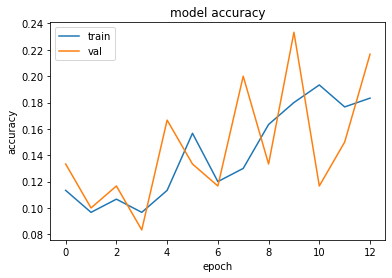

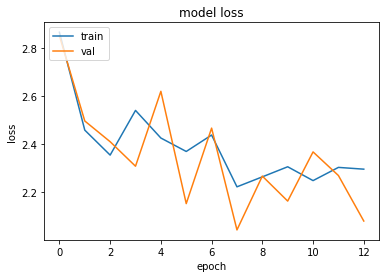

Time taken:  2771.2995948791504


In [12]:
with tf.device('/device:GPU:0'):
  Tframes=12
  batch_size=10
  nLstmUnits=1000
  params = {'dim': (Tframes,224,224,3),
            'batch_size': batch_size,
            'n_classes': 8,
            'shuffle': True}

  # Generators
  training_generator = DataGenerator(partition['train'], labels, **params)
  validation_generator = DataGenerator(partition['validation'], labels, **params)


  model=createModel4(Tframes=Tframes,nLstmUnits=nLstmUnits)
  begin=time.time()
  history=model.fit_generator(epochs=13,verbose=2,generator=training_generator,
                    validation_data=validation_generator)
  end=time.time()

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  print("Time taken: ",end-begin)

In [ ]:
#this is good news accuracy went up and loss went down but we need more epochs but we do not have processing power